# Laboratorio 4: KNN

Clase de Alexandre Gramfort, Anne Sabourin, y Joseph Salmon

Actualizado por Valentin Barriere

Integrantes: Nahuel Won y Tomás Ubilla

## Instrucciones

1.  Trabajen en equipos de dos personas. Salvo excepciones, no se corregirá entregas con menos de dos integrantes.

2.  Modifique este archivo `.ipynb` agregando sus respuestas donde corresponda.

3.  Para cada pregunta **incluya el código fuente que utilizó para llegar a su respuesta. Respuestas sin código no recibirán puntaje.**.

4.  El formato de entrega para esta actividad es un archivo **html**. **Genere un archivo HTML usando Jupyter** y súbalo a U-Cursos. Basta con que un/a integrante haga la entrega. Si ambos/as hacen una entrega en U-Cursos, se revisará cualquiera de éstas.


#### **Se recomienda fuertemente que no usen ChatGPT para resolver la actividad, ya que la experiencia de aprendizaje es mucho mayor si lo hacen por su cuenta.**

## Recordatorios  

### Definiciones y Notación

Recordamos aquí el marco de trabajo de la clasificación supervisada y presentamos las notaciones que se utilizarán a lo largo del laboratorio.

- $\mathcal{Y}$ es el conjunto de etiquetas de los datos. Aquí trabajamos con un número arbitrario $L$ de clases, y elegimos $\mathcal{Y} = \{1,\dots, L\}$ para representar las $L$ etiquetas posibles. El caso de clasificación binaria corresponde a $L=2$.  

- $\mathbf{x} = (x_1,\dots,x_p)^\top \in \mathcal{X} \subset \mathbb{R}^p$ es una observación, un ejemplo o un punto de muestra. La $j$-ésima coordenada de $\mathbf{x}$ es el valor tomado por la $j$-ésima variable (característica).  

- $\mathcal{D}_n = \{(\mathbf{x}_i , y_i), i=1,\dots, n\}$ es el conjunto de entrenamiento que contiene los $n$ ejemplos y sus etiquetas.  

- Existe un modelo probabilístico que gobierna la generación de nuestras observaciones a través de las variables aleatorias $X$ e $Y$: $\forall i \in \{1,\dots,n\},  (\mathbf{x}_i , y_i) \stackrel{i.i.d.}{\sim} (X,Y)$.  

- Nuestro objetivo es construir, a partir del conjunto de entrenamiento $\mathcal{D}_n$, una función llamada **clasificador**, $\hat{f}:\mathcal{X} \rightarrow \mathcal{Y}$, que asigne a un nuevo punto $\mathbf{x}_{\text{nuevo}}$ una etiqueta $\hat{f}(\mathbf{x}_{\text{nuevo}})$.

### Generación de Datos Artificiales  

En esta sección, consideramos observaciones descritas en dos dimensiones (para facilitar la visualización), lo que significa que $p=2$ en el formalismo anterior. Utilizamos funciones que generan conjuntos de datos artificiales del script `tp_knn_source.py`, con modificaciones únicamente en los valores de las etiquetas.  

1. **Estudia las funciones `rand_tri_gauss`, `rand_clown` y `rand_checkers`.**  
   - ¿Qué devuelven estas funciones?  
   - ¿A qué corresponde la última columna?

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from tp_knn_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d,
                           frontiere)

############################################################################
#     Generación de datos
############################################################################

n = 100
mu = [1., 1.]
sigma = [1., 1.]
rand_gauss(n, mu, sigma)

n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
data1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
data2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
data3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
data4 = rand_checkers(n1, n2, sigma)

R: 

2. Utiliza la función `plot_2d` para visualizar los conjuntos de datos.

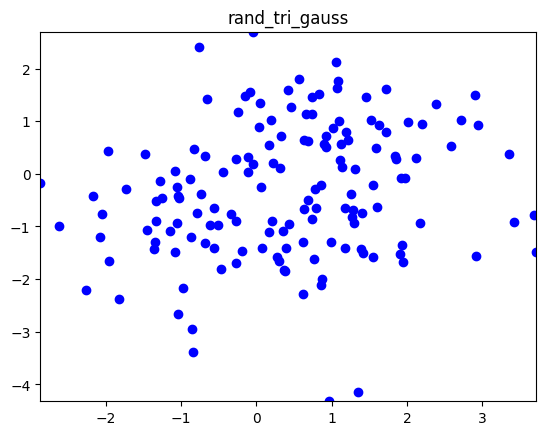

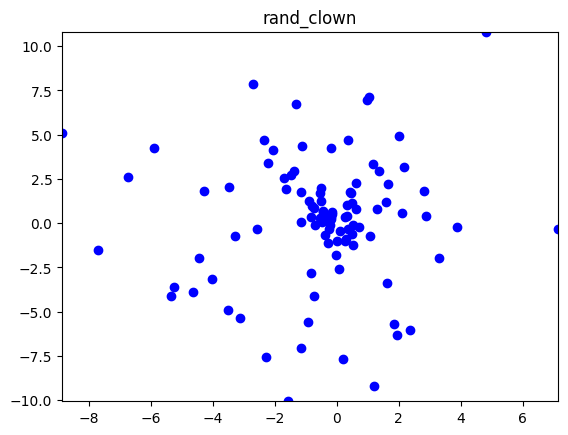

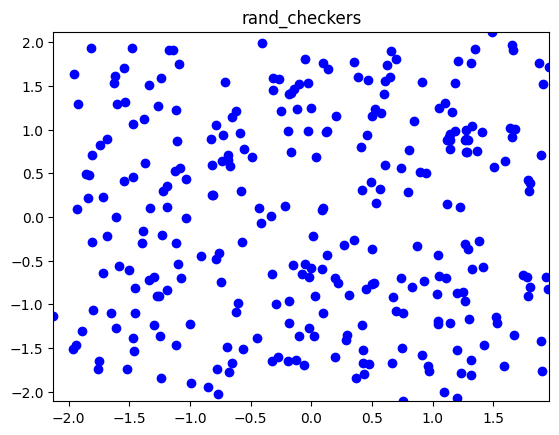

In [16]:
# ...
plot_2d(data2)
plt.title('rand_tri_gauss')
plt.show()

plot_2d(data3)
plt.title('rand_clown')
plt.show()

plot_2d(data4)
plt.title('rand_checkers')
plt.show()



## El Método de los $k$-Vecinos Más Cercanos  

### Enfoque Intuitivo  

El algoritmo de los $k$-vecinos más cercanos (**$k$-nn**) es un método intuitivo y fácil de ajustar para abordar problemas de clasificación con cualquier número de etiquetas.  

El principio del algoritmo es simple: para cada nuevo punto $\mathbf{x}$, primero determinamos el conjunto de sus $k$ vecinos más cercanos entre los puntos de entrenamiento, que denotamos como $V_k(\mathbf{x})$ (por supuesto, debemos elegir $1 \leq k \leq n$ para que esto tenga sentido). La clase asignada al nuevo punto $\mathbf{x}$ es entonces la **clase mayoritaria** dentro del conjunto $V_k(\mathbf{x})$. En la siguiente figura se muestra una ilustración del método para el caso de tres clases.

### Ilustración

![Visualización](knn.png "Ejemplo de cómo funciona el método de los k-vecinos más cercanos para valores de parámetro k=5 y k=11. Consideramos tres clases, L=3, representadas respectivamente en negro (y=1), gris (y=2) y blanco (y=3)")

Ejemplo de cómo funciona el método de los k-vecinos más cercanos para valores de parámetro k=5 y k=11. Consideramos tres clases, L=3, representadas respectivamente en negro (y=1), gris (y=2) y blanco (y=3)

1. Proponga una versión adaptada de este método para **regresión**, *es decir*, cuando las observaciones tienen valores reales: $\mathcal{Y} = \mathbb{R}$.

R: Para la regresión se debe elegir un número de k vecinos igual que en el método KNN. Ahora a diferencia del modelo KNN, para la predicción, se debe promediar el valor de las etiquetas reales de los k vecinos más cercanos. 

## Enfoque Formal

Para definir con precisión el método, primero debemos elegir una distancia $d: \mathbb{R}^p \times \mathbb{R}^p \rightarrow \mathbb{R}$. Para un nuevo punto $\mathbf{x}$, definimos entonces el conjunto de sus $k$-vecinos más cercanos $V_k(\mathbf{x})$ usando esta distancia. Procedemos de la siguiente manera:

Para cada $\mathbf{x} \in \mathbb{R}^p$ y cada $i = 1, \ldots, n$, denotamos $d_i(\mathbf{x})$ como la distancia entre $\mathbf{x}$ y $\mathbf{x}_i$:
$$
d_i(\mathbf{x}) = d(\mathbf{x}_i, \mathbf{x}).
$$

Definimos el estadístico de primer orden $r_1(\mathbf{x})$ como el índice del vecino más cercano a $\mathbf{x}$ entre $\mathbf{x}_1, \ldots, \mathbf{x}_n$, es decir:
$$
r_1(\mathbf{x}) = i^* \quad \text{si y solo si} \quad d_{i^*}(\mathbf{x}) = \min_{1 \le i \le n} d_i(\mathbf{x}).
$$

> **Nota**  
> Si hay múltiples candidatos para el mínimo anterior, los empates se resuelven arbitrariamente (generalmente al azar).

Por inducción, podemos definir el rango $r_k(\mathbf{x})$ para cualquier entero $1 \leq k \leq n$:
$$
r_k(\mathbf{x}) = i^* \quad \text{si y solo si} \quad
d_{i^*}(\mathbf{x}) = \min_{\substack{1 \le i \le n \\ i \notin \{r_1, \ldots, r_{k-1}\}}} d_i(\mathbf{x}).
$$

El conjunto de los $k$-vecinos más cercanos de $\mathbf{x}$ se escribe entonces:
$$
V_k(\mathbf{x}) = \{ \mathbf{x}_{r_1}, \dots, \mathbf{x}_{r_k} \}.
$$

Finalmente, la decisión para clasificar el punto $\mathbf{x}$ se toma por votación mayoritaria, resolviendo el siguiente problema:

$$
\hat{f}_k(\mathbf{x}) \in \arg\max_{y \in \mathcal{Y}} \left( \sum_{j=1}^k \mathbb{1}_{\{Y_{r_j} = y\}} \right).
$$

El módulo `sklearn.neighbors` de **scikit-learn** implementa métodos de clasificación y regresión basados en los $k$-vecinos más cercanos.  
Consulta la documentación: [scikit-learn.neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

2. Completa la clase `KNNClassifier`.  
   Verifica la exactitud de los resultados comparando con la clase `KNeighborsClassifier` de **scikit-learn**.  
   Propón **tu propio método de comparación**.


In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        predictions = []
        # TODO : Calcular todas las distancias por pares entre X y self.X_
        for x in X:
            distance = np.linalg.norm(self.X_ - x, axis=1)

            nearestK = np.argsort(distance)[:self.n_neighbors]

            neighbor = self.y_[nearestK]
            label = np.bincount(neighbor.astype(int))
            majority = np.argmax(label)

            predictions.append(majority)

        # TODO : Encuentre las etiquetas predichas Y para cada entrada X
        # Puede utilizar la función scipy.stats.mode

        return np.zeros(n_samples)

# TODO : Compare su implementación con scikit-learn
from sklearn import neighbors

# Conjunto de datos 2
X_train = data2[::2, :2]
Y_train = data2[::2, 2]
X_test = data2[1::2, :2]
Y_test = data2[1::2, 2]

# ...
knnClass = KNNClassifier(n_neighbors=3)
knnClass.fit(X_train, Y_train)
y_pred = knnClass.predict(X_test)

ski_knn = neighbors.KNeighborsClassifier(n_neighbors=3)
ski_knn.fit(X_train, Y_train)
y_pred_ski = ski_knn.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_knnClass = accuracy_score(Y_test, y_pred)
accuracy_ski_knn = accuracy_score(Y_test, y_pred_ski)

# De ahora en adelante utilice la implementación de scikit-learn
plt.ion()
print('diferencias entre KNNClasssifier y KNeighboursClassifier =', np.sum(y_pred != y_pred_ski))


diferencias entre KNNClasssifier y KNeighboursClassifier = 75


**Nota**: Para ahorrar en tiempo de cómputo, deberás utilizar la implementación de **scikit-learn**!

3. Ejecuta el algoritmo de clasificación en los tres conjuntos de datos de ejemplo,  
   utilizando la **distancia euclidiana clásica**:  
   $$
   d(\mathbf{x}, \mathbf{v}) = \| \mathbf{x} - \mathbf{v} \|_2
   $$

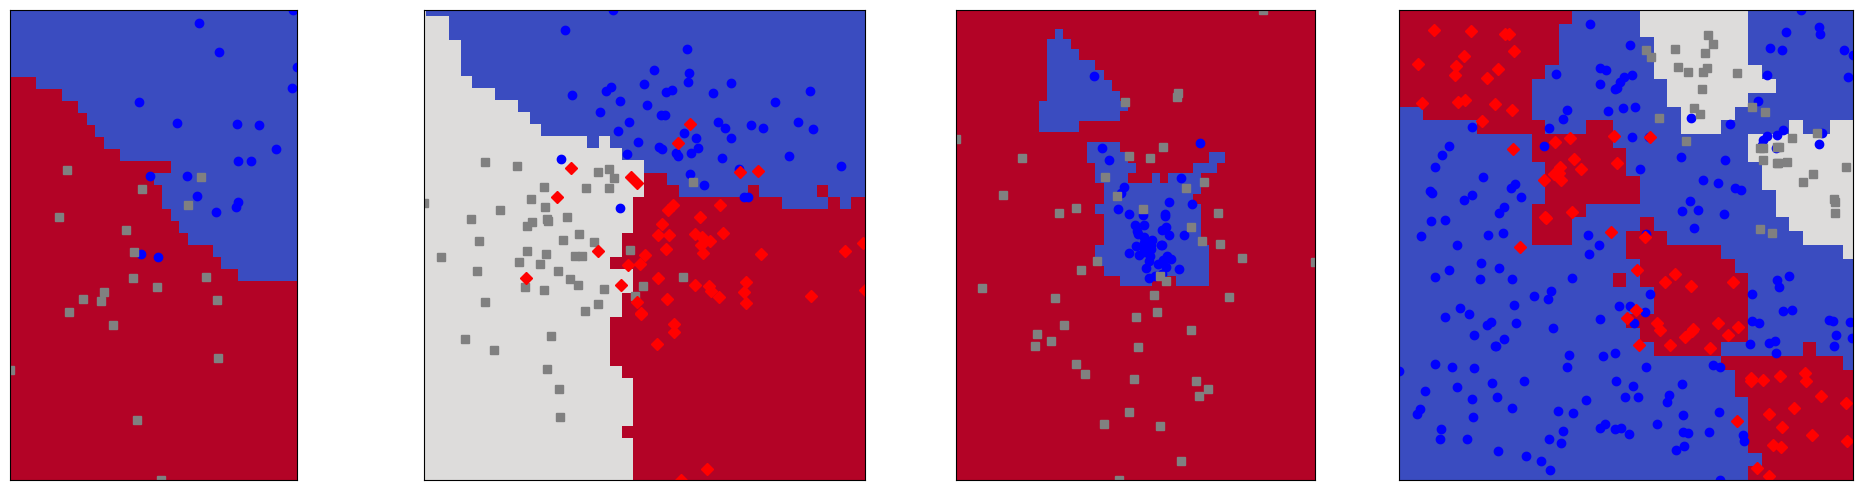

In [18]:
n_neighbors = 5  # la k en k-NN
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

plt.figure(figsize=(20, 5))
for i, data in enumerate([data1, data2, data3, data4]):
    # TODO : Entrenar el clasificador KNN con los datos de entrenamiento
    X = data[:, :2]
    Y = data[:, 2].astype(int)

    knn.fit(X, Y)
    # TODO : Generar un gráfico con los puntos y la frontera de decisión del clasificador
    plt.subplot(1, 4, i+1)
    plot_2d(X, Y)
    frontiere(knn.predict, X, step=50, tiny=True)
    pass
plt.tight_layout()

4. Varía el número $k$ de vecinos considerados.  
   - ¿En qué se convierte el método en los casos extremos cuando $k=1$? ¿Y cuando $k=n$?  
   - Muestra estos casos en los datos estudiados.  
   - ¿En qué casos el **límite de decisión es complejo**? ¿**simple**?

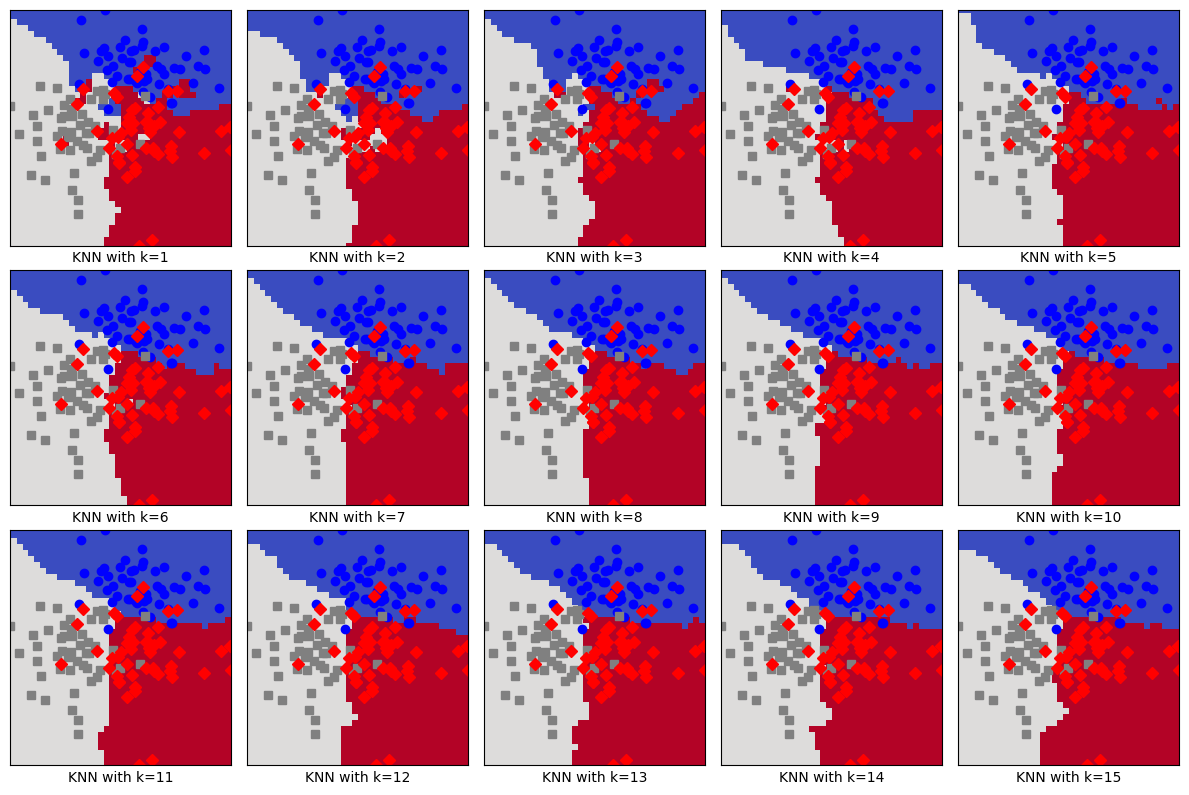

In [19]:
plt.figure(3, figsize=(12, 8))
for n_neighbors in range(1, 16):
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

    # TODO : Entrene el knn
    X_train = data2[:, :2]
    Y_train = data2[:, 2].astype(int)

    knn.fit(X_train, Y_train)
    
    plt.subplot(3, 5, n_neighbors)
    plt.xlabel('KNN with k=%d' % n_neighbors)
    plot_2d(X_train, Y_train)
    frontiere(knn.predict, X_train, step=50, tiny=True)
plt.tight_layout()

R: Cuando k = 1, el modelo es altamente sensible al ruido, tiende a 'aprender' todos los datos, lo cual significa que tiene un límite de decisión complejo y es sujeto a un riesgo de overfitting. 
Cuando k = n, el modelo ignora el ruido, tiene un límite de decisión simple y tiene riesgo de underfitting. 

5. Una variante ampliamente utilizada consiste en **ponderar los votos** del j-ésimo vecino mediante la siguiente fórmula:  
   $$
   e^{-d_j^2 / h}
   $$
   (donde $h$ controla el nivel de ponderación).

   Esto equivale a reemplazar la ecuación de votación mayoritaria por:

   $$
   \hat{f}_k(\mathbf{x}) \in \arg\max_{y \in \mathcal{Y}} \left( \sum_{j=1}^k \exp\left(-\frac{d_j^2}{h}\right) \mathbb{I}_{\{Y_{r_j} = y\}} \right)
   $$

   - Implementa esta variante en tu clase `KNNClassifier`
   - También impleméntala usando scikit-learn pasando el parámetro `weights` al constructor de `KNeighborsClassifier`
   - Puedes inspirarte en la función `_weight_func` de las pruebas de scikit-learn: [Enlace a prueba de scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/tests/test_neighbors.py)

   - **Prueba el impacto de la elección de $h$** en los límites de clasificación

[1 3 2 2 2 1 2 1 1 3 3 3 2 3 1 2 2 3 2 2 2 1 2 2 1 1 3 1 3 1 2 3 2 2 1 3 3
 1 2 1 3 3 1 3 1 3 3 2 2 3 3 2 3 1 1 1 3 3 1 3 1 3 2 1 2 3 2 3 2 2 1 2 3 3
 2 2 2 2 2 1 1 2 3 2 2 1 3 1 1 3 1 1 2 1 1 1 3 3 2 3 1 3 1 1 2 1 3 1 1 1 3
 3 1 1 2 3 3 1 3 3 1 2 2 1 2 2 2 3 3 1 3 2 3 1 3 1 1 2 2 1 2 1 2 1 1 3 3 2
 2 2]


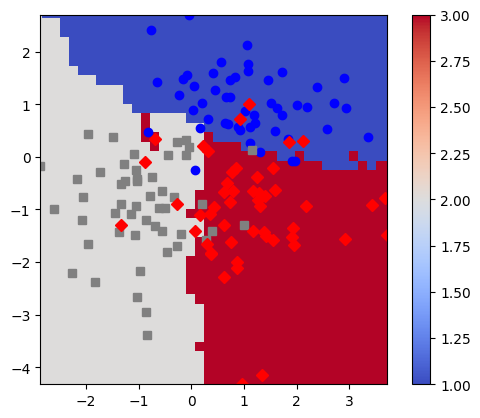

In [20]:
def weights(dist, h=10.0):
    """
    Devuelve un array de pesos, que disminuyen exponencialmente al cuadrado
    de la distancia.

    Parámetros
    ----------
    dist : un array unidimensional de distancias.

    Retorna
    -------
    weight : array del mismo tamaño que dist
    """
    # TODO
    return np.exp(-(dist**2)/h)

n_neighbors = 5
wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
wknn.fit(X_train, Y_train)
plt.figure(4)
plot_2d(X_train, Y_train)
frontiere(wknn.predict, X_train, step=50)

print(wknn.predict(X_train))

Comente sus resultados

R:

6. ¿Cuál es la **tasa de error** en tus datos de entrenamiento (es decir, la proporción de errores cometidos por el clasificador) cuando $k = 1$?

    Use el método [`score()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score)

In [21]:
# ...
k = 1
knn2 = neighbors.KNeighborsClassifier(n_neighbors=k)
knn2.fit(X_train, Y_train)

accuracyKnn2 = knn2.score(X_train, Y_train)
errorKnn2 = 1 - accuracyKnn2

print("tasa de error:", errorKnn2)

tasa de error: 0.0


7. Grafica las **curvas de error** en función de $k$ para uno de los conjuntos de datos,  
   con tamaños de muestra $n$ que varíen entre $100$, $500$ y $1000$.

   - ¿Cuál es el mejor valor de $k$?
   - ¿Es siempre el mismo para los diferentes conjuntos de datos?
   - Asegúrate de evaluar el error en los **datos de prueba**.
   - Puedes utilizar la clase proporcionada `ErrorCurve`.

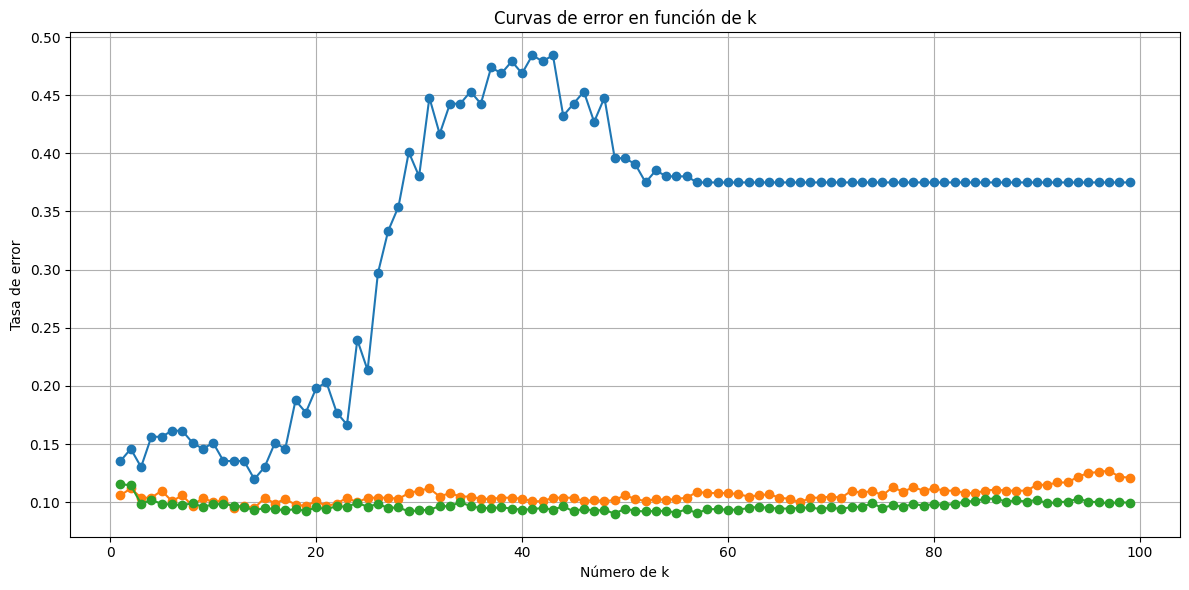

In [22]:
# Preparar
sigma = 0.1
range_n_samples = [100, 500, 1000]
k_range = range(1, 100)

# Función auxiliar para generar los conjuntos de entrenamiento y prueba
def generate_train_test(n, sigma):
    data = rand_checkers(n, n, sigma)
    X_train, Y_train = data[:, :2], data[:, 2]
    data_test = rand_checkers(n, n, sigma)
    X_test, Y_test = data_test[:, :2], data_test[:, 2]
    return X_train, Y_train, X_test, Y_test

plt.figure(figsize=(12, 6))
from tp_knn_source import ErrorCurve
# TODO : Graficar la curva de error para cada valor de k y n_samples
for n in range_n_samples:
    X_train, Y_train, X_test, Y_test = generate_train_test(n, sigma)

    error_curve = ErrorCurve(k_range=k_range)
    error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
    error_curve.plot(label=f"n = {n}")


plt.xlabel("Número de k")
plt.ylabel("Tasa de error")
plt.title("Curvas de error en función de k")
plt.grid(True)
plt.tight_layout()
plt.show()
# Curva azul: n=100
# Curva naranja: n=500
# Curva verde: n=1000

R: El mejor k será el que minimize la taza de error. Para n=100 vemos que el mejor k se encuentra más cercano al 20. Para n=500 el mejor k se ubica cerca del k=10 y k=20 y para n=1000 se encuentra en un punto cercano al k=20. Así se puede observar que no siempre es el mismo para los diferentes conjuntos de datos.

8. En tu opinión, ¿cuáles son las **ventajas** y **desventajas** del método de los vecinos más cercanos?  
   - ¿Tiempo de cálculo?  
   - ¿Escalabilidad?  
   - ¿Interpretabilidad?

R:

9. Aplica el método al conjunto de datos **`digits`** con diferentes elecciones de $k \geq 1$. 

    Consulta: [plot_digits_classification.py — scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)

<class 'sklearn.utils._bunch.Bunch'>
Score : 0.9254727474972191


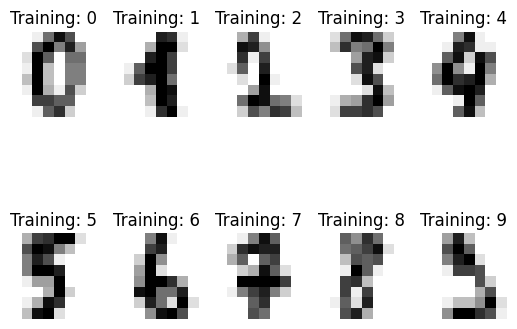

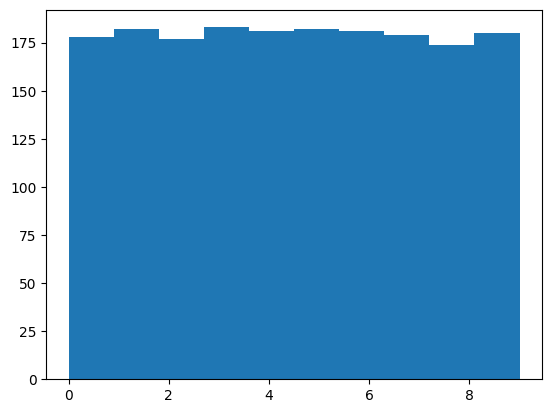

In [23]:
# import sklearn
from sklearn import datasets

# El conjunto de datos de dígitos
digits = datasets.load_digits()

print(type(digits))
# Un Bunch es una subclase de 'dict' (dictionary)
# help(dict)
# vea también "http://docs.python.org/2/library/stdtypes.html#mapping-types-dict"

plt.close(7)
plt.figure(7)
for index, (img, label) in enumerate(list(zip(digits.images, digits.target))[10:20]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: %i' % label)

plt.figure()
plt.hist(digits.target)

n_samples = len(digits.data)

X_train = digits.data[:n_samples // 2]
Y_train = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]

knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, Y_train)

score = knn.score(X_test, Y_test)
print('Score : %s' % score)

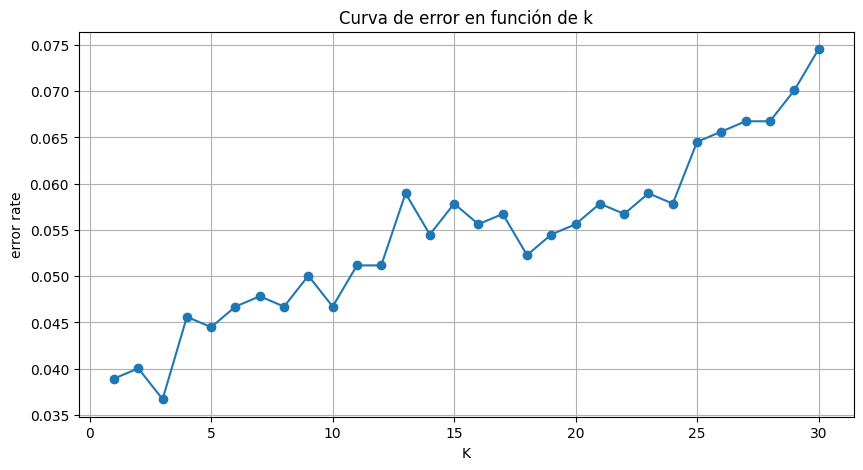

In [24]:
# TODO : Probar con distintos valores de k y comparar el rendimiento
# Pueden usar ErrorCurve
k_range = range(1, 31)

ec = ErrorCurve(k_range=k_range)
ec.fit_curve(X_train, Y_train, X_test, Y_test)

plt.figure(figsize=(10, 5))
ec.plot()
plt.title("Curva de error en función de k")
plt.grid(True)
plt.show()



10. Grafica la **matriz de confusión** $\left( \mathbb{P}\{Y = i, C_k(X) = j\} \right)_{i, j}$ asociada al clasificador $C_k$. 

    Para manejar estas matrices con scikit-learn, consulta: [Ejemplo de matriz de confusión — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

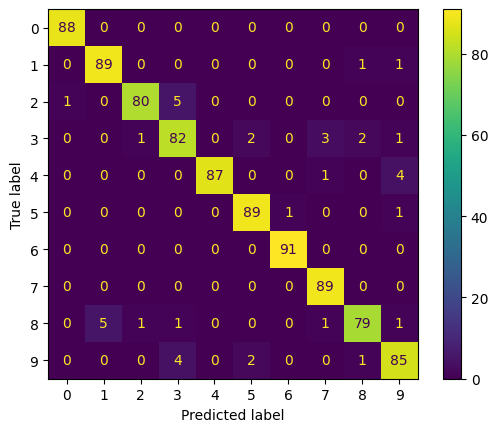

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
k = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

# TODO : Graficar la matriz de confusión

confusion = confusion_matrix(Y_test, Y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=knn.classes_)

disp.plot()
plt.show()

11. Propón un **método para seleccionar $k$** e impleméntalo. Puedes utilizar la clase proporcionada `LOOCurve`.

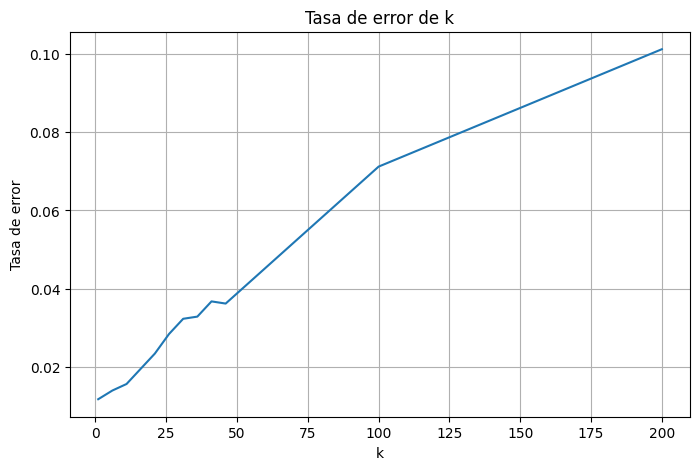

In [27]:
# Revise la clase 'LOOCurve', en el archivo fuente

from tp_knn_source import LOOCurve

loo_curve = LOOCurve(k_range=list(range(1, 50, 5)) + list(range(100, 300, 100)))
loo_curve.fit_curve(digits.data, digits.target)
# TODO : Graficar LOOCurve

plt.figure(figsize=(8, 5))
plt.plot(loo_curve.k_range, 1 - loo_curve.cv_scores,) 
plt.title("Tasa de error de k")
plt.xlabel("k")
plt.ylabel("Tasa de error")
plt.grid(True)
plt.show()

¿De qué forma elegiría usando `LOOCurve` k?

R: Elegir el k que entrega el mejor score promedio en la curva